In [1]:
#!/usr/bin/env python
# # -*- coding: utf-8 -*-
#!/usr/bin/env python
#!pip install tensorflow==1.15

import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os, inspect
import argparse
import time
import seaborn as sns
# import matplotlib
# matplotlib.use("Qt5Agg")
# #matplotlib.use('Agg')
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
import pandas as pd
import sys,inspect
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Postprocess")
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Methods\\Models\\Utils")

import utils  # for utils.py
from utils import *
import global_utils  # for global_utils.py

# import utils
# from utils import *
# import sys
# sys.path.append('../Methods/Models/Utils')
# import global_utils

In [2]:
sysname, tidx = "SST", 2
file_path = os.path.abspath("HQRC_analysis.ipynb")
current_directory = os.path.dirname(file_path)
mid_directory = os.path.dirname(current_directory)
parent_directory = os.path.dirname(mid_directory)

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

#current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
results_dir = os.path.join(os.path.dirname(mid_directory), "Results")  # Use os.path.join for path concatenation
print(results_dir)

eval_path = os.path.join(results_dir, sysname, 'Evaluation_Data')
print(eval_path)

model_path = os.path.join(results_dir, sysname, 'Trained_Models')
print(model_path)

fig_path = os.path.join(results_dir, sysname, 'Eval_Figures')
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)  # Use os.makedirs to create parent directories if needed
print(fig_path)

Current Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Data\SST
Parent Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Evaluation_Data
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Trained_Models
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST\Eval_Figures


In [3]:
models = []
samples = []
size_values = [40, 50, 60, 70, 80, 100, 120, 150, 200, 300, 500, 1000]
beta_values = [1e-04,1e-05,1e-06,1e-07]
for size in size_values:
    for beta in beta_values:
        string1 = f"ESN_pinv-RDIM_5-N_used_427-SIZE_{size}-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_{beta}-NICS_3"
        string2 = f"ESN-{size}-beta-{beta}"
        models.append([os.path.join(eval_path,string1),string2])
        samples.append(string2)
title = "Sea Surface Temperatures"

In [4]:
rmse_dict = dict()
targets = dict()
outputs = dict()
targets_train = dict()
outputs_train = dict()
sp_outputs = dict()
sp_targets = dict()
Wouts = dict()
coeffs = dict()
rmnse_avg_train_dict = dict()
rmnse_avg_test_dict = dict()
for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'results.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            qs = QResults()
            qs.rmnse_avg_test = rs['rmnse_avg_TEST']
            qs.rmnse_avg_train = rs['rmnse_avg_TRAIN']
            qs.n_pred_005_avg_test = rs['num_accurate_pred_005_avg_TEST']
            qs.n_pred_005_avg_train = rs['num_accurate_pred_005_avg_TRAIN']
            qs.n_pred_050_avg_test = rs['num_accurate_pred_050_avg_TEST']
            qs.n_pred_050_avg_train = rs['num_accurate_pred_050_avg_TRAIN']
            qs.model_name = rs['model_name']
            #if qs.rmnse_avg_test != np.inf and qs.rmnse_avg_train != np.inf:
                #print(rs.keys())
            #print(qs.model_name)
            #print('train={}, test={}'.format(qs.rmnse_avg_train, qs.rmnse_avg_test))
            #qs.info()
            rmnse_avg_train_dict[label] = rs['rmnse_avg_TRAIN']
            rmnse_avg_test_dict[label] = rs['rmnse_avg_TEST']
            pred_test = rs['predictions_all_TEST']
            truth_test = rs['truths_all_TEST']
            pred_train = rs['predictions_all_TRAIN']
            truth_train =rs['truths_all_TRAIN']
            print(pred_test.shape)
            M = len(pred_test)
            print('{} Number of test'.format(qs.model_name), M)
            rmsels = []
            for j in range(M):
                    rmsels.append(calNRMSE(pred_test[j], truth_test[j]))

            rmse_dict[label] = np.mean(np.array(rmsels), axis=0)
            print(rmse_dict[label].shape)


            targets[label] = truth_test[0] #0th test 
            outputs[label] = pred_test[0]

            targets_train[label] = truth_train[0] #0th test 
            outputs_train[label] = pred_train[0]
            # For frequency
            sp_outputs[label] = rs['sp_pred_TEST']
            sp_targets[label] = rs['sp_true_TEST']
    else:
        print('Not found {}'.format(fname))
    # if trained_models is not None:
    #     rfolder, label = trained_models[i][0], trained_models[i][1]
    #     fname = os.path.join(rfolder, 'data.pickle')
    #     if os.path.isfile(fname):
    #         print('File existed: ', fname)
    #         with open(fname, 'rb') as rfile:
    #             #try:
    #             rs = pickle.load(rfile)
    #             #except:
    #             #    continue
    #             print(rs.keys())
    #             coeffs[label] = np.array(rs['coeffs'])
    #             Wouts[label]  = rs['W_out'][:-1].reshape((coeffs[label].shape[0], -1))
    #             print(Wouts[label].shape, coeffs[label].shape)
    #     else:
    #         print('Not found saved model {}'.format(fname))

(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_40-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_0.0001-NICS_3 Number of test 3
(300,)
(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_40-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_1e-05-NICS_3 Number of test 3
(300,)
(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_40-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_1e-06-NICS_3 Number of test 3
(300,)
(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_40-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_1e-07-NICS_3 Number of test 3
(300,)
(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_50-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_0.0001-NICS_3 Number of test 3
(300,)
(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_50-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_1e-05-NICS_3 Number of test 3
(300,)
(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_50-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_1e-06-NICS_3 Number of test 3
(300,)
(3, 300, 5)
ESN_pinv-RDIM_5-N_used_427-SIZE_50-D_10.0

In [5]:
#Manually calculated ignore
model_test_error = []
test_avg_error = []
for label in samples:
    model_test_error.append([label,np.mean(rmse_dict[label])])
    test_avg_error.append(np.mean(rmse_dict[label]))
print(model_test_error)
print("Test Average error = ",np.mean(test_avg_error))

[['ESN-40-beta-0.0001', 1.5734693006857077], ['ESN-40-beta-1e-05', 1.6090941126369767], ['ESN-40-beta-1e-06', 1.6127680476567106], ['ESN-40-beta-1e-07', 1.6130774555297716], ['ESN-50-beta-0.0001', 1.5545752294331516], ['ESN-50-beta-1e-05', 1.5235024305284177], ['ESN-50-beta-1e-06', 1.509340331960348], ['ESN-50-beta-1e-07', 1.508134580481681], ['ESN-60-beta-0.0001', 1.4753170299488578], ['ESN-60-beta-1e-05', 1.336575122297645], ['ESN-60-beta-1e-06', 1.309580405948595], ['ESN-60-beta-1e-07', 1.307837479778843], ['ESN-70-beta-0.0001', 1.4282677088988995], ['ESN-70-beta-1e-05', 1.4228258658709028], ['ESN-70-beta-1e-06', 1.4191587967854669], ['ESN-70-beta-1e-07', 1.4185005160633342], ['ESN-80-beta-0.0001', 1.5959267426348027], ['ESN-80-beta-1e-05', 1.9176490935859356], ['ESN-80-beta-1e-06', 2.105502275514598], ['ESN-80-beta-1e-07', 2.1239969867527946], ['ESN-100-beta-0.0001', 1.270591392324601], ['ESN-100-beta-1e-05', 1.3849607011093357], ['ESN-100-beta-1e-06', 1.4488139181660535], ['ESN-10

In [6]:
print(rmnse_avg_train_dict)
print(rmnse_avg_test_dict)
error_array_test = []
error_array_train = []
for label in samples:
    error_array_train.append(rmnse_avg_train_dict[label])
    error_array_test.append(rmnse_avg_test_dict[label])
print("Train average error for HQRC =", np.mean(error_array_train))
print("Test average error for HQRC =", np.mean(error_array_test))

{'ESN-40-beta-0.0001': 1.0286135402142362, 'ESN-40-beta-1e-05': 1.0229695252826092, 'ESN-40-beta-1e-06': 1.0214323974731414, 'ESN-40-beta-1e-07': 1.021261638921574, 'ESN-50-beta-0.0001': 0.906913589971537, 'ESN-50-beta-1e-05': 0.7932797731696611, 'ESN-50-beta-1e-06': 0.7725811789493003, 'ESN-50-beta-1e-07': 0.7745008557885108, 'ESN-60-beta-0.0001': 0.5268432138512865, 'ESN-60-beta-1e-05': 0.520062875441265, 'ESN-60-beta-1e-06': 0.5279717065983763, 'ESN-60-beta-1e-07': 0.5289043299427124, 'ESN-70-beta-0.0001': 0.8404729572576431, 'ESN-70-beta-1e-05': 0.8477383879414733, 'ESN-70-beta-1e-06': 0.844558011689118, 'ESN-70-beta-1e-07': 0.8442502725396445, 'ESN-80-beta-0.0001': 0.8997073919899061, 'ESN-80-beta-1e-05': 1.1681746367183148, 'ESN-80-beta-1e-06': 1.2029280269128868, 'ESN-80-beta-1e-07': 1.2769176622454805, 'ESN-100-beta-0.0001': 0.7686406308700968, 'ESN-100-beta-1e-05': 0.9278910127342659, 'ESN-100-beta-1e-06': 1.008046836322104, 'ESN-100-beta-1e-07': 1.0806888105470531, 'ESN-120-b

In [7]:
#Sort the dictionary by its values
sorted_rmnse_train = sorted(rmnse_avg_train_dict.items(), key=lambda item: item[1])

#Extract the top 5 keys with the lowest values
#top_5_models_train = [key for key, value in sorted_rmnse_train[:5]]
top_5_models_train = dict(sorted_rmnse_train[:5])
print("Top 5 models with the lowest RMNSE values for training data:", top_5_models_train)

Top 5 models with the lowest RMNSE values for training data: {'ESN-60-beta-1e-05': 0.520062875441265, 'ESN-60-beta-0.0001': 0.5268432138512865, 'ESN-60-beta-1e-06': 0.5279717065983763, 'ESN-60-beta-1e-07': 0.5289043299427124, 'ESN-100-beta-0.0001': 0.7686406308700968}


In [8]:
# Step 1: Sort the dictionary by its values
sorted_rmnse_test = sorted(rmnse_avg_test_dict.items(), key=lambda item: item[1])

# Step 2: Extract the top 5 keys with the lowest values
#top_5_models_train = [key for key, value in sorted_rmnse_train[:5]]
top_5_models_test = dict(sorted_rmnse_test[:5])
print("Top 5 models with the lowest RMNSE values for test data:", top_5_models_test)

Top 5 models with the lowest RMNSE values for test data: {'ESN-200-beta-0.0001': 1.081561445813232, 'ESN-60-beta-1e-07': 1.0833544858348954, 'ESN-60-beta-1e-06': 1.0858892580663682, 'ESN-60-beta-1e-05': 1.1171461811165906, 'ESN-100-beta-0.0001': 1.119168735550098}


In [9]:
predictions = []
truths = []
for keys in top_5_models_train:
    predictions.append(outputs_train[keys])
    truths.append(targets_train[keys])
mean_train_predictions = np.mean(predictions, axis=0)
std_train_predictions = np.std(predictions, axis=0)
print("Mean predictions shape:", mean_train_predictions.shape)
print("Standard deviation shape:", std_train_predictions.shape)
print("Mean predictions:\n", mean_train_predictions)
print("Standard deviation:\n", std_train_predictions)
mean_train_truths = np.mean(truths, axis=0)
std_train_truths = np.std(truths, axis=0)
# print("Mean predictions shape:", mean_truths.shape)
# print("Standard deviation shape:", std_truths.shape)
# print("Mean predictions:\n", mean_truths)
# print("Standard deviation:\n", std_truths)

Mean predictions shape: (300, 5)
Standard deviation shape: (300, 5)
Mean predictions:
 [[-378.82245249  -57.39697284   72.47120698    9.26249799   21.01878275]
 [-412.3726756   -48.74058729   85.09334548    7.96240548   19.66727453]
 [-439.4602464   -38.62985943   93.68065952    8.91500385   16.56485452]
 ...
 [ 459.51188064  -29.87874894    8.51093736   24.95825814  -38.95315376]
 [ 424.12425772  -37.73311183   -1.97875182   27.85136891  -37.48438941]
 [ 381.7941974   -45.57081879  -13.87696281   29.86928772  -35.27173724]]
Standard deviation:
 [[  1.6094484    1.03237519   2.48268399   1.44554762   1.58384866]
 [  0.52536014   2.03486068   4.13962747   1.57108276   0.76084133]
 [  0.816225     2.1280258    6.00651872   0.22878693   0.90756589]
 ...
 [147.459563    44.528503    31.75506929   6.90462415  13.51087489]
 [157.3389433   43.94803851  34.42452057   8.59334784  14.07488627]
 [167.19760936  42.75508394  43.01222731  10.70664767  14.7588628 ]]


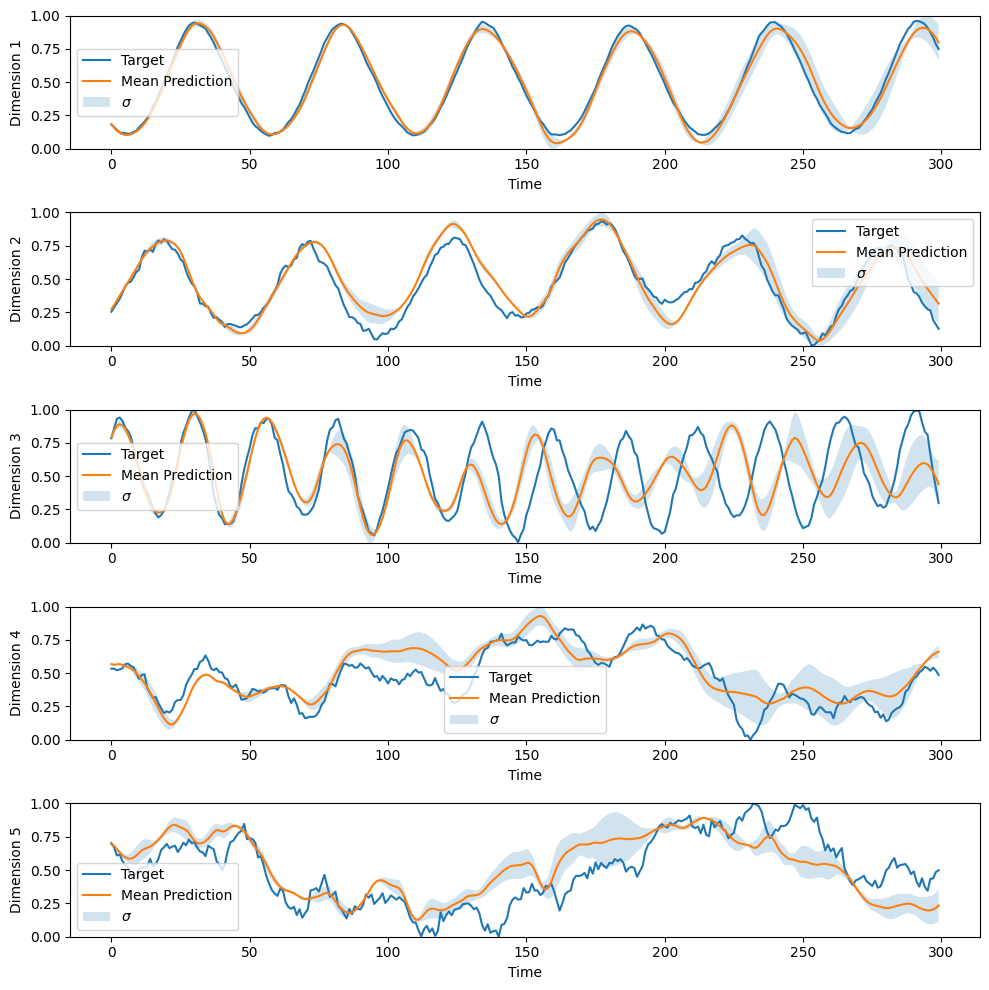

In [10]:
num_dimensions = mean_train_truths.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(10, 10))

# Iterate over each dimension
for dim in range(num_dimensions):
    # Extract arrays for the current dimension
    target_dim = mean_train_truths[:, dim]
    out_dim = mean_train_predictions[:, dim]
    std_dim = std_train_predictions[:, dim]

    # Calculate min and max values across all arrays for current dimension
    data_min = min(np.min(target_dim), np.min(out_dim - std_dim))
    data_max = max(np.max(target_dim), np.max(out_dim + std_dim))

    # Normalize arrays to [0, 1] range
    target_dim = (target_dim - data_min) / (data_max - data_min)
    out_dim = (out_dim - data_min) / (data_max - data_min)
    std_dim = std_dim / (data_max - data_min)  # std deviation is normalized accordingly

    # Plot target and output arrays
    axs[dim].plot(target_dim, label='Target')
    axs[dim].plot(out_dim, label='Mean Prediction')
    axs[dim].fill_between(range(len(out_dim)), out_dim - std_dim, out_dim + std_dim, alpha=0.2, label=r'$\sigma$')

    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)

    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim + 1}')
    axs[dim].legend()

# Add title
#plt.suptitle('Target and Mean Prediction for Each Dimension on train data, for top 5 models of ESN')
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()

In [11]:
predictions = []
truths = []
for keys in top_5_models_train:
    predictions.append(outputs[keys])
    truths.append(targets[keys])
mean_test_predictions = np.mean(predictions, axis=0)
std_test_predictions = np.std(predictions, axis=0)
print("Mean predictions shape:", mean_test_predictions.shape)
print("Standard deviation shape:", std_test_predictions.shape)
print("Mean predictions:\n", mean_test_predictions)
print("Standard deviation:\n", std_test_predictions)
mean_test_truths = np.mean(truths, axis=0)
std_test_truths = np.std(truths, axis=0)
# print("Mean predictions shape:", mean_truths.shape)
# print("Standard deviation shape:", std_truths.shape)
# print("Mean predictions:\n", mean_truths)
# print("Standard deviation:\n", std_truths)

Mean predictions shape: (300, 5)
Standard deviation shape: (300, 5)
Mean predictions:
 [[468.28282712 -27.68726745  30.78603668 -85.26006266  20.85415568]
 [476.51644109 -35.35614373  10.17415754 -87.52029302  19.12016707]
 [473.89964834 -41.66222651 -11.9879659  -95.03043943  17.46588783]
 ...
 [284.15426423  -5.198906   -14.5285062   -4.46177333 -42.37668677]
 [284.52722336  -8.75090329  -8.36897409   2.08569467 -42.8281935 ]
 [282.16100566 -11.22916234  -2.65185488   8.91793185 -43.09808664]]
Standard deviation:
 [[7.78130808e+00 7.19124753e-02 9.40621898e+00 9.92415954e+00
  3.38275043e+00]
 [1.11586866e+01 1.00872433e+00 1.47550674e+01 1.66986689e+01
  3.32575628e+00]
 [1.23042052e+01 1.13004656e-01 2.21719045e+01 2.09984645e+01
  2.65235315e+00]
 ...
 [3.84023797e+02 2.81510119e+01 2.68275324e+01 3.64688231e+01
  2.96371611e+00]
 [3.77106514e+02 2.72673525e+01 3.90080498e+01 3.74690334e+01
  4.96700619e+00]
 [3.67356199e+02 2.87290182e+01 4.83759223e+01 3.82191068e+01
  7.0745744

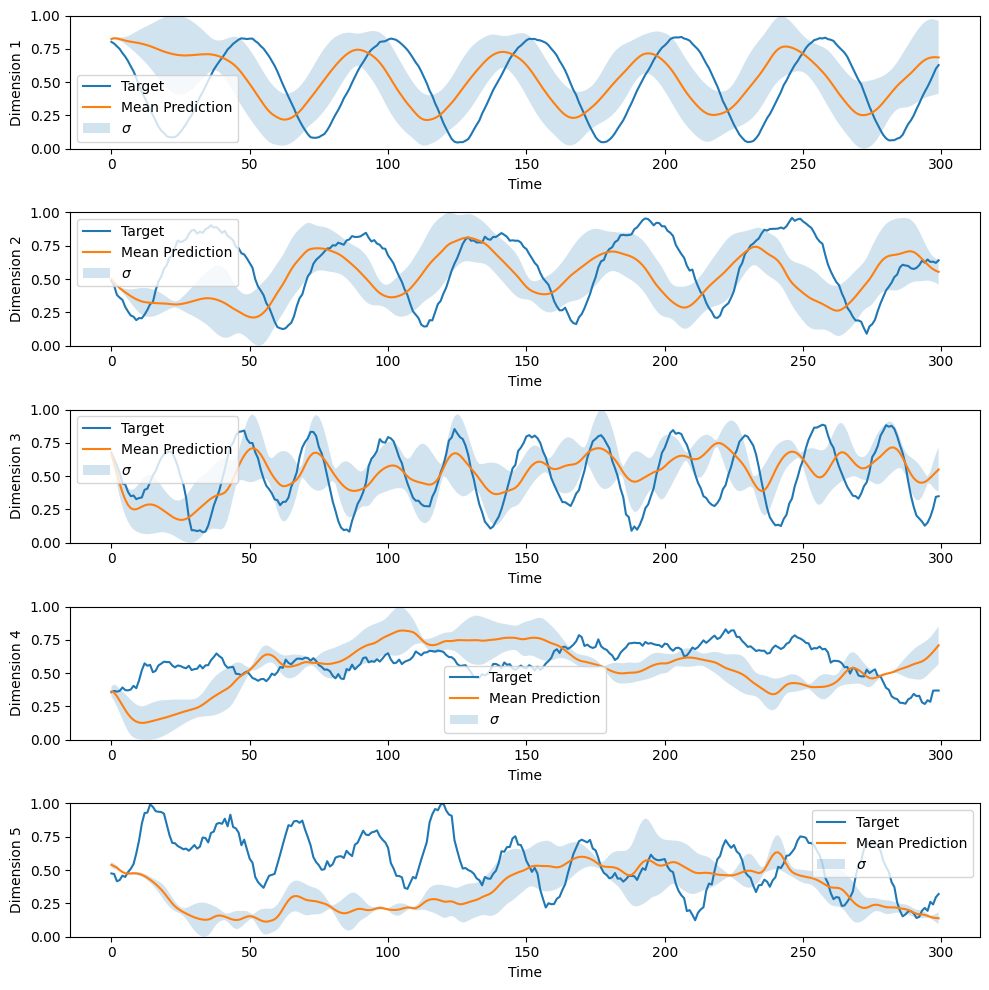

In [12]:
num_dimensions = mean_test_truths.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(10, 10))

# Iterate over each dimension
for dim in range(num_dimensions):
    # Extract arrays for the current dimension
    target_dim = mean_test_truths[:, dim]
    out_dim = mean_test_predictions[:, dim]
    std_dim = std_test_predictions[:, dim]

    # Calculate min and max values across all arrays for current dimension
    data_min = min(np.min(target_dim), np.min(out_dim - std_dim))
    data_max = max(np.max(target_dim), np.max(out_dim + std_dim))

    # Normalize arrays to [0, 1] range
    target_dim = (target_dim - data_min) / (data_max - data_min)
    out_dim = (out_dim - data_min) / (data_max - data_min)
    std_dim = std_dim / (data_max - data_min)  # std deviation is normalized accordingly

    # Plot target and output arrays
    axs[dim].plot(target_dim, label='Target')
    axs[dim].plot(out_dim, label='Mean Prediction')
    axs[dim].fill_between(range(len(out_dim)), out_dim - std_dim, out_dim + std_dim, alpha=0.2, label=r'$\sigma$')

    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)

    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim + 1}')
    axs[dim].legend()

# Add title
#plt.suptitle('Target and Mean Prediction for Each Dimension on test data, for top 5 models of ESN')
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()

## Reconstruction of Temperature map along and error analysis

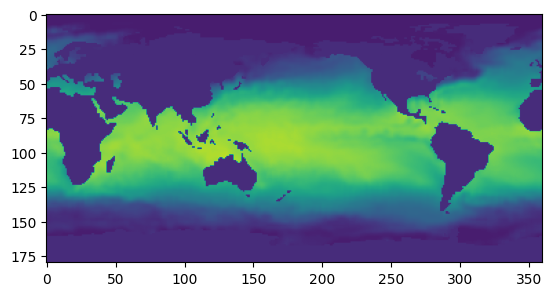

In [13]:
train_data = np.load('Data/sst_var_train',allow_pickle=True).data
test_data = np.load('Data/sst_var_test',allow_pickle=True).data
mask = np.load('Data/mask',allow_pickle=True)
#plt.imshow(train_data[0]*mask[0],vmin=-5,vmax=35)
plt.imshow(test_data[0]*mask[0],vmin=-5,vmax=35)

In [14]:
train_data_ml = train_data.reshape(427,180*360)
mask = mask[0].flatten()
mask = np.asarray(mask,dtype='bool')

train_data_ml = train_data_ml[:,mask]
train_data_ml.shape

# Find train data mean
train_data_mean = np.mean(train_data_ml,axis=0)
train_data_ml = train_data_ml - train_data_mean[None,]

In [15]:
test_data_ml = test_data.reshape(1487,180*360)
mask = np.load('Data/mask',allow_pickle=True)
mask = mask[0].flatten()
mask = np.asarray(mask,dtype='bool')

test_data_ml = test_data_ml[:,mask]
test_data_ml.shape

# Find train data mean
test_data_mean = np.mean(test_data_ml,axis=0)
test_data_ml = test_data_ml - test_data_mean[None,]

In [16]:
def field_compression(Y,K):
    '''
    Y - Snapshot matrix - shape: NxS
    K - number of modes to truncate to
    returns 
    V - truncated POD basis matrix - shape: NxK
    Ytilde - truncated coefficient matrix - shape: KxS
    '''
    V = generate_pod_bases(Y,K)
    Ytilde = field_coefficients(Y,V)

    return V, Ytilde

def generate_pod_bases(Y,K): #Mean removed
    '''
    Y - Snapshot matrix - shape: NxS
    returns V - truncated POD basis matrix - shape: NxK
    '''
    new_mat = np.matmul(np.transpose(Y),Y)
    w,v = np.linalg.eig(new_mat)

    # plt.figure()
    # plt.semilogy(w[:]/np.sum(w)*100)
    # plt.show()

    # Bases
    V = np.real(np.matmul(Y,v)) 
    trange = np.arange(np.shape(V)[1])
    V[:,trange] = V[:,trange]/np.sqrt(w[:])

    # Truncate phis
    V = V[:,0:K] # Columns are modes

    return V

def field_coefficients(Y,V):
    '''
    Y - Snapshot matrix - shape: NxS
    V - truncated POD basis matrix - shape: NxK
    returns Ytilde - shape: KxS
    '''
    return np.matmul(np.transpose(V),Y)

In [17]:
modes, coeffs = field_compression(train_data_ml.T,5)
modes_test, coeffs_test = field_compression(test_data_ml.T,5)

c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\hqr2-venv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


In [18]:
N_train=427
with open("./Data/testing_data_N{:d}.pickle".format(N_train), "rb") as file:
    data = pickle.load(file)
    data_test = data["test_input_sequence"]
    del data
with open("./Data/training_data_N{:d}.pickle".format(N_train), "rb") as file:
    data = pickle.load(file)
    data_train = data["train_input_sequence"]
    del data

In [19]:
np.allclose(data_train[116+300-1],targets_train[samples[0]][299])
#check

True

In [20]:
print(data_train[116+300-1])
print(mean_train_truths[299])
print(mean_train_predictions[299])
#check

[321.8648    -99.581604  -48.89029    -8.7071905  -2.9636319]
[321.8648    -99.581604  -48.890293   -8.7071905  -2.9636319]
[381.7941974  -45.57081879 -13.87696281  29.86928772 -35.27173724]


In [21]:
test_ic = [116,40,66] #taken from randomly generated test indices from the data_analysis.ipynb file
pl_max = 300
dl_max = test_ic[0]
recon_data_ml = np.matmul(modes,data_train[test_ic[0]:test_ic[0]+pl_max].T).T
recon_data_ml = recon_data_ml + train_data_mean[None,]
recon_data = np.copy(train_data[test_ic[0]:test_ic[0]+pl_max])
recon_data = recon_data.reshape(pl_max,180*360)
recon_data[:,mask] = recon_data_ml
recon_data = recon_data.reshape(pl_max,180,360)

pred_data_ml = np.matmul(modes,mean_train_predictions.T).T
pred_data_ml = pred_data_ml + train_data_mean[None,]
pred_data = np.copy(train_data[test_ic[0]:test_ic[0]+pl_max])
pred_data = pred_data.reshape(pl_max,180*360)
pred_data[:,mask] = pred_data_ml
pred_data = pred_data.reshape(pl_max,180,360)
new_mask = np.load('Data/mask',allow_pickle=True)
#check if correctly done

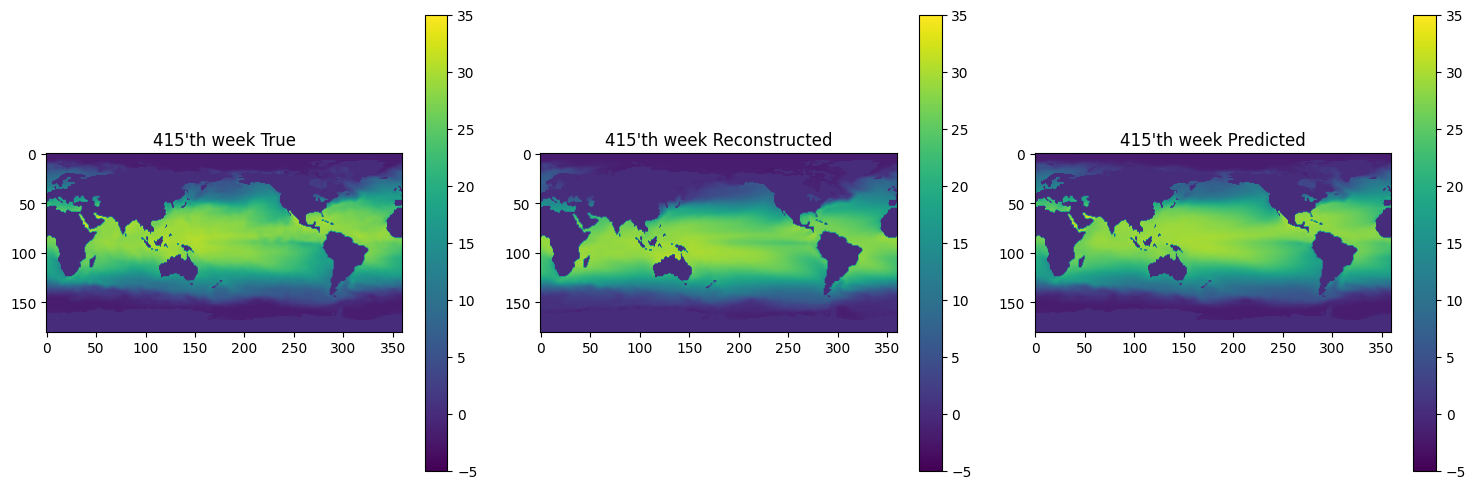

In [22]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
im1 = axs[0].imshow(train_data[dl_max+pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[0].set_title("{}'th week True".format(dl_max+pl_max-1))
fig.colorbar(im1, ax=axs[0], orientation='vertical')


# Plot the second subplot
im2 = axs[1].imshow(recon_data[0] * new_mask[0], vmin=-5, vmax=35)
axs[1].set_title("{}'th week Reconstructed".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Plot the third subplot
im3 = axs[2].imshow(pred_data[pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[2].set_title("{}'th week Predicted".format(dl_max+pl_max-1))
fig.colorbar(im3, ax=axs[2], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

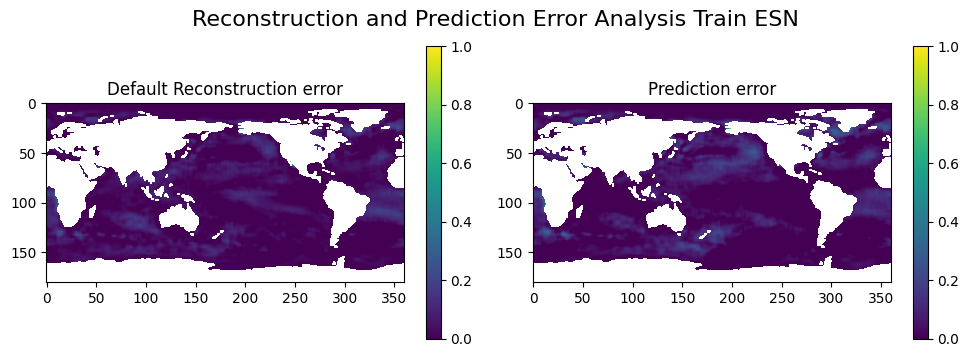

In [23]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
masked_recon_error = np.ma.array(np.mean(train_data[dl_max:dl_max+pl_max]-recon_data,axis=0), mask=new_mask[0] == 0)
im1 = axs[0].imshow(masked_recon_error, vmin=0.0, vmax=1.0)
axs[0].set_title("Default Reconstruction error")
fig.colorbar(im1, ax=axs[0], orientation='vertical', shrink=0.5)  # Shrink the color bar

# Plot the second subplot
masked_pred_error = np.ma.array(np.mean(train_data[dl_max:dl_max+pl_max]-pred_data,axis=0), mask=new_mask[0] == 0)
im2 = axs[1].imshow(masked_pred_error, vmin=0.0, vmax=1)
axs[1].set_title("Prediction error")  # 415th week prediction error (dl_max+pl_max-1)
fig.colorbar(im2, ax=axs[1], orientation='vertical', shrink=0.5)  # Shrink the color bar

# Add a title to the entire figure
fig.suptitle('Reconstruction and Prediction Error Analysis Train ESN', fontsize=16)

# Adjust layout
plt.tight_layout()

# Adjust layout to make room for the figure title
plt.subplots_adjust(top=1.2)  # Adjust the top to make room for suptitle

# Show the figure
plt.show()

In [24]:
recon_train = recon_data
pred_grid_train = pred_data

In [25]:
temp_true = train_data[dl_max:dl_max+pl_max]
rmse_pred = np.sqrt(np.mean((temp_true-pred_data)**2))
print(rmse_pred)

0.5964944


## For East Pacific Region

In [26]:
temp_true_ep = train_data[dl_max:dl_max+pl_max,80:100,200:250]
temp_pred_ep = pred_data[:,80:100,200:250]
rmse_pred = np.sqrt(np.mean((temp_true_ep-temp_pred_ep)**2))
print(rmse_pred)

0.78005147


## For test data

In [27]:
test_ic = [116,40,66] #taken from randomly generated test indices from the data_analysis.ipynb file
pl_max = 300
dl_max = test_ic[0]
recon_data_ml = np.matmul(modes_test,data_test[test_ic[0]:test_ic[0]+pl_max].T).T
recon_data_ml = recon_data_ml + test_data_mean[None,]
recon_data = np.copy(test_data[test_ic[0]:test_ic[0]+pl_max])
recon_data = recon_data.reshape(pl_max,180*360)
recon_data[:,mask] = recon_data_ml
recon_data = recon_data.reshape(pl_max,180,360)

pred_data_ml = np.matmul(modes_test,mean_test_predictions.T).T
pred_data_ml = pred_data_ml + test_data_mean[None,]
pred_data = np.copy(test_data[test_ic[0]:test_ic[0]+pl_max])
pred_data = pred_data.reshape(pl_max,180*360)
pred_data[:,mask] = pred_data_ml
pred_data = pred_data.reshape(pl_max,180,360)
new_mask = np.load('Data/mask',allow_pickle=True)
#check if correctly done

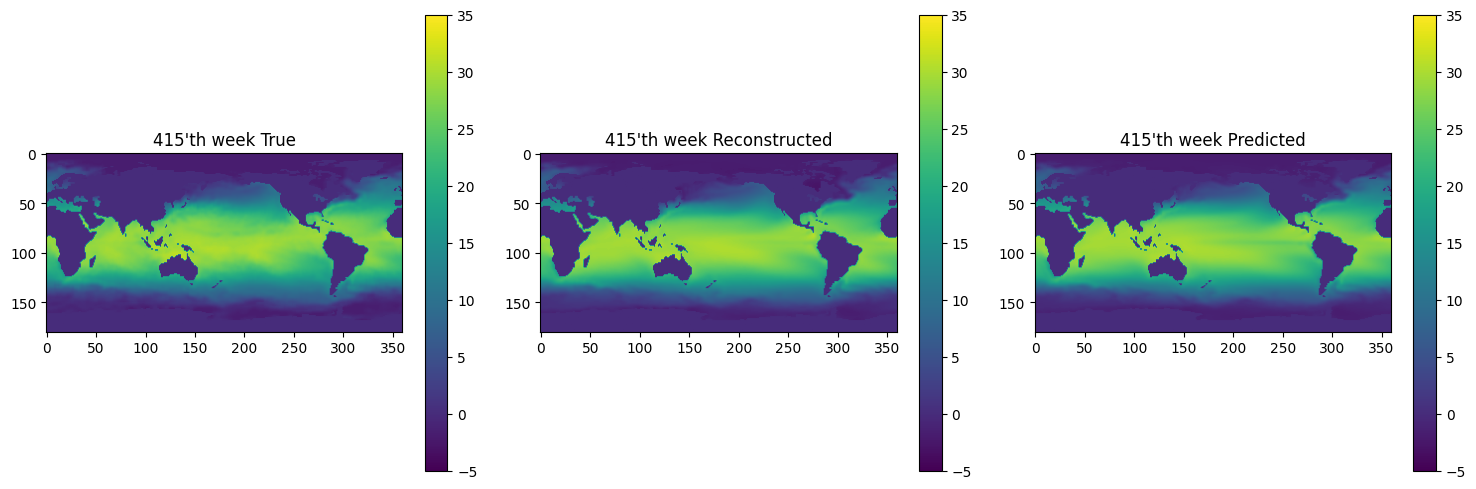

In [28]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
im1 = axs[0].imshow(test_data[dl_max+pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[0].set_title("{}'th week True".format(dl_max+pl_max-1))
fig.colorbar(im1, ax=axs[0], orientation='vertical')


# Plot the second subplot
im2 = axs[1].imshow(recon_data[0] * new_mask[0], vmin=-5, vmax=35)
axs[1].set_title("{}'th week Reconstructed".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Plot the third subplot
im3 = axs[2].imshow(pred_data[pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[2].set_title("{}'th week Predicted".format(dl_max+pl_max-1))
fig.colorbar(im3, ax=axs[2], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

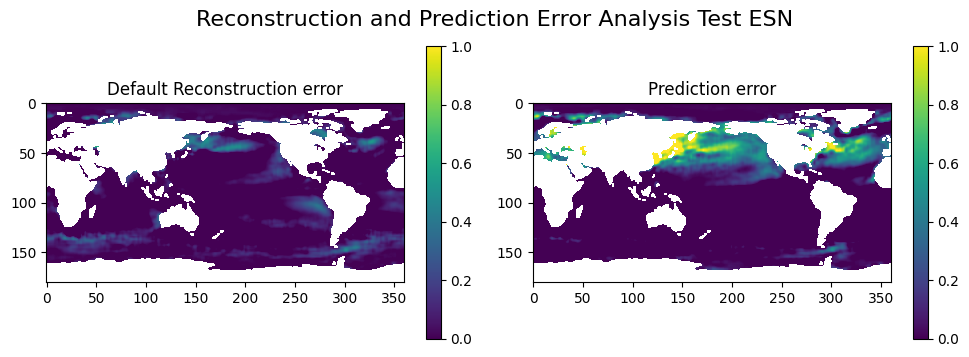

In [29]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
masked_recon_test_error = np.ma.array(np.mean(test_data[dl_max:dl_max+pl_max]-recon_data,axis=0),mask=new_mask[0]==0)
im1 = axs[0].imshow(masked_recon_test_error, vmin=0.0, vmax=1)
axs[0].set_title("Default Reconstruction error")
fig.colorbar(im1, ax=axs[0], orientation='vertical', shrink=0.5)

# Plot the second subplot
masked_pred_test_error = np.ma.array(np.mean(test_data[dl_max:dl_max+pl_max]-pred_data,axis=0),mask=new_mask[0]==0)
im2 = axs[1].imshow(masked_pred_test_error, vmin=0.0, vmax=1)
axs[1].set_title("Prediction error")
fig.colorbar(im2, ax=axs[1], orientation='vertical', shrink=0.5)

fig.suptitle('Reconstruction and Prediction Error Analysis Test ESN', fontsize=16)

# Adjust layout
plt.tight_layout()

# Adjust layout to make room for the figure title
plt.subplots_adjust(top=1.2)  # Adjust the top to make room for suptitle

In [30]:
recon_test = recon_data
pred_grid_test = pred_data

In [31]:
temp_true = test_data[dl_max:dl_max+pl_max]
rmse_pred = np.sqrt(np.mean((temp_true-pred_data)**2))
print(rmse_pred)

1.7700726


## For East Pacific Region

In [32]:
temp_true_ep = test_data[dl_max:dl_max+pl_max,80:100,200:250]
temp_pred_ep = pred_data[:,80:100,200:250]
rmse_pred = np.sqrt(np.mean((temp_true_ep-temp_pred_ep)**2))
print(rmse_pred)

1.5807791


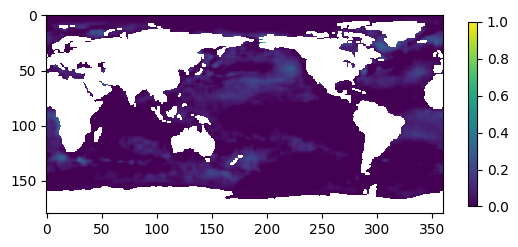

In [33]:
masked_pred_train_error = np.ma.array(np.mean(train_data[dl_max:dl_max+pl_max]-pred_grid_train,axis=0),mask=new_mask[0]==0)
plt.figure()
im1 = plt.imshow(masked_pred_train_error, vmin=0.0, vmax=1)
#plt.title("ESN Average Prediction Error Train")
plt.colorbar(im1, orientation='vertical', shrink=0.5)

# Show the plot
plt.show()

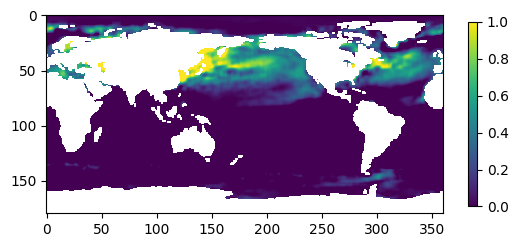

In [34]:
masked_pred_test_error = np.ma.array(np.mean(test_data[dl_max:dl_max+pl_max]-pred_grid_test,axis=0),mask=new_mask[0]==0)
plt.figure()
im1 = plt.imshow(masked_pred_test_error, vmin=0.0, vmax=1)
#plt.title("ESN Average Prediction Error Test")
plt.colorbar(im1, orientation='vertical', shrink=0.5)

# Show the plot
plt.show()

## Memory and computation time analysis

In [35]:
models = []
samples = []
size_values = [40, 50, 60, 70, 80, 100, 120, 150, 200, 300, 500, 1000]
beta_values = [1e-04,1e-05,1e-06,1e-07]
for size in size_values:
    for beta in beta_values:
        string1 = f"ESN_pinv-RDIM_5-N_used_427-SIZE_{size}-D_10.0-RADIUS_0.9-SIGMA_1.0-DL_40-NL_0-IPL_300-REG_{beta}-NICS_3"
        string2 = f"ESN-{size}-beta-{beta}"
        models.append([os.path.join(model_path,string1),string2])
        samples.append(string2)
title = "Sea Surface Temperatures"

In [36]:
train_time_dict = dict()
memory_dict = dict()
trainable_parameters_dict = dict()
for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'data.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            train_time_dict[label]=rs["total_training_time"]
            trainable_parameters_dict[label]=rs["n_trainable_parameters"]
            memory_dict[label]=rs["memory"]
    else:
        print('Not found {}'.format(fname))

In [37]:
train_time_dict

{'ESN-40-beta-0.0001': 0.07060956954956055,
 'ESN-40-beta-1e-05': 0.03247404098510742,
 'ESN-40-beta-1e-06': 0.026305675506591797,
 'ESN-40-beta-1e-07': 0.032341718673706055,
 'ESN-50-beta-0.0001': 0.03415942192077637,
 'ESN-50-beta-1e-05': 0.02760934829711914,
 'ESN-50-beta-1e-06': 0.04063677787780762,
 'ESN-50-beta-1e-07': 0.04118037223815918,
 'ESN-60-beta-0.0001': 0.0658261775970459,
 'ESN-60-beta-1e-05': 0.02880573272705078,
 'ESN-60-beta-1e-06': 0.039751529693603516,
 'ESN-60-beta-1e-07': 0.04214644432067871,
 'ESN-70-beta-0.0001': 0.0415501594543457,
 'ESN-70-beta-1e-05': 0.040671348571777344,
 'ESN-70-beta-1e-06': 0.03334355354309082,
 'ESN-70-beta-1e-07': 0.03283548355102539,
 'ESN-80-beta-0.0001': 0.04497265815734863,
 'ESN-80-beta-1e-05': 0.03903365135192871,
 'ESN-80-beta-1e-06': 0.10244226455688477,
 'ESN-80-beta-1e-07': 0.05604839324951172,
 'ESN-100-beta-0.0001': 0.20865750312805176,
 'ESN-100-beta-1e-05': 0.046622276306152344,
 'ESN-100-beta-1e-06': 0.04074263572692871,

In [38]:
values = train_time_dict.values()
total = sum(values)
average = total / len(values)
print(average)

0.13575191795825958


In [39]:
memory_dict

{'ESN-40-beta-0.0001': 97.06640625,
 'ESN-40-beta-1e-05': 98.5,
 'ESN-40-beta-1e-06': 97.29296875,
 'ESN-40-beta-1e-07': 98.375,
 'ESN-50-beta-0.0001': 98.57421875,
 'ESN-50-beta-1e-05': 98.56640625,
 'ESN-50-beta-1e-06': 97.35546875,
 'ESN-50-beta-1e-07': 97.46484375,
 'ESN-60-beta-0.0001': 97.6953125,
 'ESN-60-beta-1e-05': 97.39453125,
 'ESN-60-beta-1e-06': 97.64453125,
 'ESN-60-beta-1e-07': 97.5,
 'ESN-70-beta-0.0001': 98.06640625,
 'ESN-70-beta-1e-05': 98.22265625,
 'ESN-70-beta-1e-06': 97.796875,
 'ESN-70-beta-1e-07': 97.98828125,
 'ESN-80-beta-0.0001': 98.203125,
 'ESN-80-beta-1e-05': 97.94140625,
 'ESN-80-beta-1e-06': 98.0078125,
 'ESN-80-beta-1e-07': 98.98828125,
 'ESN-100-beta-0.0001': 98.359375,
 'ESN-100-beta-1e-05': 99.39453125,
 'ESN-100-beta-1e-06': 98.89453125,
 'ESN-100-beta-1e-07': 99.17578125,
 'ESN-120-beta-0.0001': 99.05859375,
 'ESN-120-beta-1e-05': 99.58984375,
 'ESN-120-beta-1e-06': 99.11328125,
 'ESN-120-beta-1e-07': 99.39453125,
 'ESN-150-beta-0.0001': 99.59375

In [40]:
values = memory_dict.values()
total = sum(values)
average = total / len(values)
print(average)

101.99951171875


In [41]:
trainable_parameters_dict

{'ESN-40-beta-0.0001': 200,
 'ESN-40-beta-1e-05': 200,
 'ESN-40-beta-1e-06': 200,
 'ESN-40-beta-1e-07': 200,
 'ESN-50-beta-0.0001': 250,
 'ESN-50-beta-1e-05': 250,
 'ESN-50-beta-1e-06': 250,
 'ESN-50-beta-1e-07': 250,
 'ESN-60-beta-0.0001': 300,
 'ESN-60-beta-1e-05': 300,
 'ESN-60-beta-1e-06': 300,
 'ESN-60-beta-1e-07': 300,
 'ESN-70-beta-0.0001': 350,
 'ESN-70-beta-1e-05': 350,
 'ESN-70-beta-1e-06': 350,
 'ESN-70-beta-1e-07': 350,
 'ESN-80-beta-0.0001': 400,
 'ESN-80-beta-1e-05': 400,
 'ESN-80-beta-1e-06': 400,
 'ESN-80-beta-1e-07': 400,
 'ESN-100-beta-0.0001': 500,
 'ESN-100-beta-1e-05': 500,
 'ESN-100-beta-1e-06': 500,
 'ESN-100-beta-1e-07': 500,
 'ESN-120-beta-0.0001': 600,
 'ESN-120-beta-1e-05': 600,
 'ESN-120-beta-1e-06': 600,
 'ESN-120-beta-1e-07': 600,
 'ESN-150-beta-0.0001': 750,
 'ESN-150-beta-1e-05': 750,
 'ESN-150-beta-1e-06': 750,
 'ESN-150-beta-1e-07': 750,
 'ESN-200-beta-0.0001': 1000,
 'ESN-200-beta-1e-05': 1000,
 'ESN-200-beta-1e-06': 1000,
 'ESN-200-beta-1e-07': 1000,